# 1.32a: Supernova Threshold Analysis

Investigating the "supernova" period in early training using lattice-cell displacement magnitudes. We want to understand when the chaotic early motion settles down and whether it could have disrupted the spongecrystal structure.

## Approach

Using pre-computed lattice displacements from `1.31c_delta_W_prime_dead.safetensors`, we compute:

1. **Fraction above threshold**: For powers of 2 from 1 to 65,536 cells, what fraction of dead tokens exceed each threshold at each timestep?
2. **Percentiles**: 50th, 75th, 90th, 95th, 99th percentiles of L2 displacement magnitude over time
3. **Mean L2 displacement**: Average displacement in lattice cells (log₂ scale)
4. **Mean L∞ displacement**: Maximum per-axis displacement (log₂ scale)

An exponent in bfloat16 spans 2^16 = 65,536 lattice cells.

## Parameters

In [73]:
DPI = 200
COLORMAP = 'inferno'

## Imports

In [74]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [75]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Lattice Displacements

In [76]:
tensor_path = Path('../tensors/Thimble/1.31c_delta_W_prime_dead.safetensors')
data = load_file(str(tensor_path))
delta_W_prime_dead = data['delta_W_prime'].to(torch.float32).to(device)

print(f"Loaded delta_W_prime_dead: {delta_W_prime_dead.shape}")  # [6000, 3699, 64]
print(f"Memory: {delta_W_prime_dead.element_size() * delta_W_prime_dead.nelement() / 1e9:.2f} GB")

Loaded delta_W_prime_dead: torch.Size([6000, 3699, 64])
Memory: 5.68 GB


## Compute Displacement Norms

In [77]:
# L2 norm: Euclidean distance in lattice cells
displacement_l2 = torch.norm(delta_W_prime_dead, p=2, dim=-1)  # [6000, 3699]

# L∞ norm: Maximum displacement along any single axis
displacement_linf = torch.norm(delta_W_prime_dead, p=float('inf'), dim=-1)  # [6000, 3699]

print(f"L2 displacement range: [{displacement_l2.min():.2f}, {displacement_l2.max():.2f}] cells")
print(f"L∞ displacement range: [{displacement_linf.min():.2f}, {displacement_linf.max():.2f}] cells")

L2 displacement range: [0.00, inf] cells
L∞ displacement range: [0.00, 1045227051521289178843185152.00] cells


## Compute Fraction Above Threshold (L2)

In [78]:
# Powers of 2 from 2^0 to 2^16 (1 to 65,536 cells)
powers = np.arange(0, 17)
thresholds = 2.0 ** powers

# Compute fraction of tokens exceeding each threshold at each timestep
fractions = []
for thresh in thresholds:
    frac = (displacement_l2 > thresh).float().mean(dim=1).cpu().numpy()  # [6000]
    fractions.append(frac)

fractions = np.array(fractions)  # [17, 6000]
print(f"Fraction-above-threshold computed: {fractions.shape}")

Fraction-above-threshold computed: (17, 6000)


## Compute Percentiles (L2)

In [79]:
percentiles = [50, 75, 90, 95, 99]
perc_values = np.percentile(displacement_l2.cpu().numpy(), percentiles, axis=1)  # [5, 6000]

print(f"Percentiles computed: {perc_values.shape}")

Percentiles computed: (5, 6000)


## Compute Mean Displacements

In [80]:
mean_l2 = displacement_l2.mean(dim=1).cpu().numpy()  # [6000]
mean_linf = displacement_linf.mean(dim=1).cpu().numpy()  # [6000]

print(f"Mean L2: {mean_l2.shape}")
print(f"Mean L∞: {mean_linf.shape}")

Mean L2: (6000,)
Mean L∞: (6000,)


## Plot 1: Smoothed Mean L2 Displacement with Threshold Lines

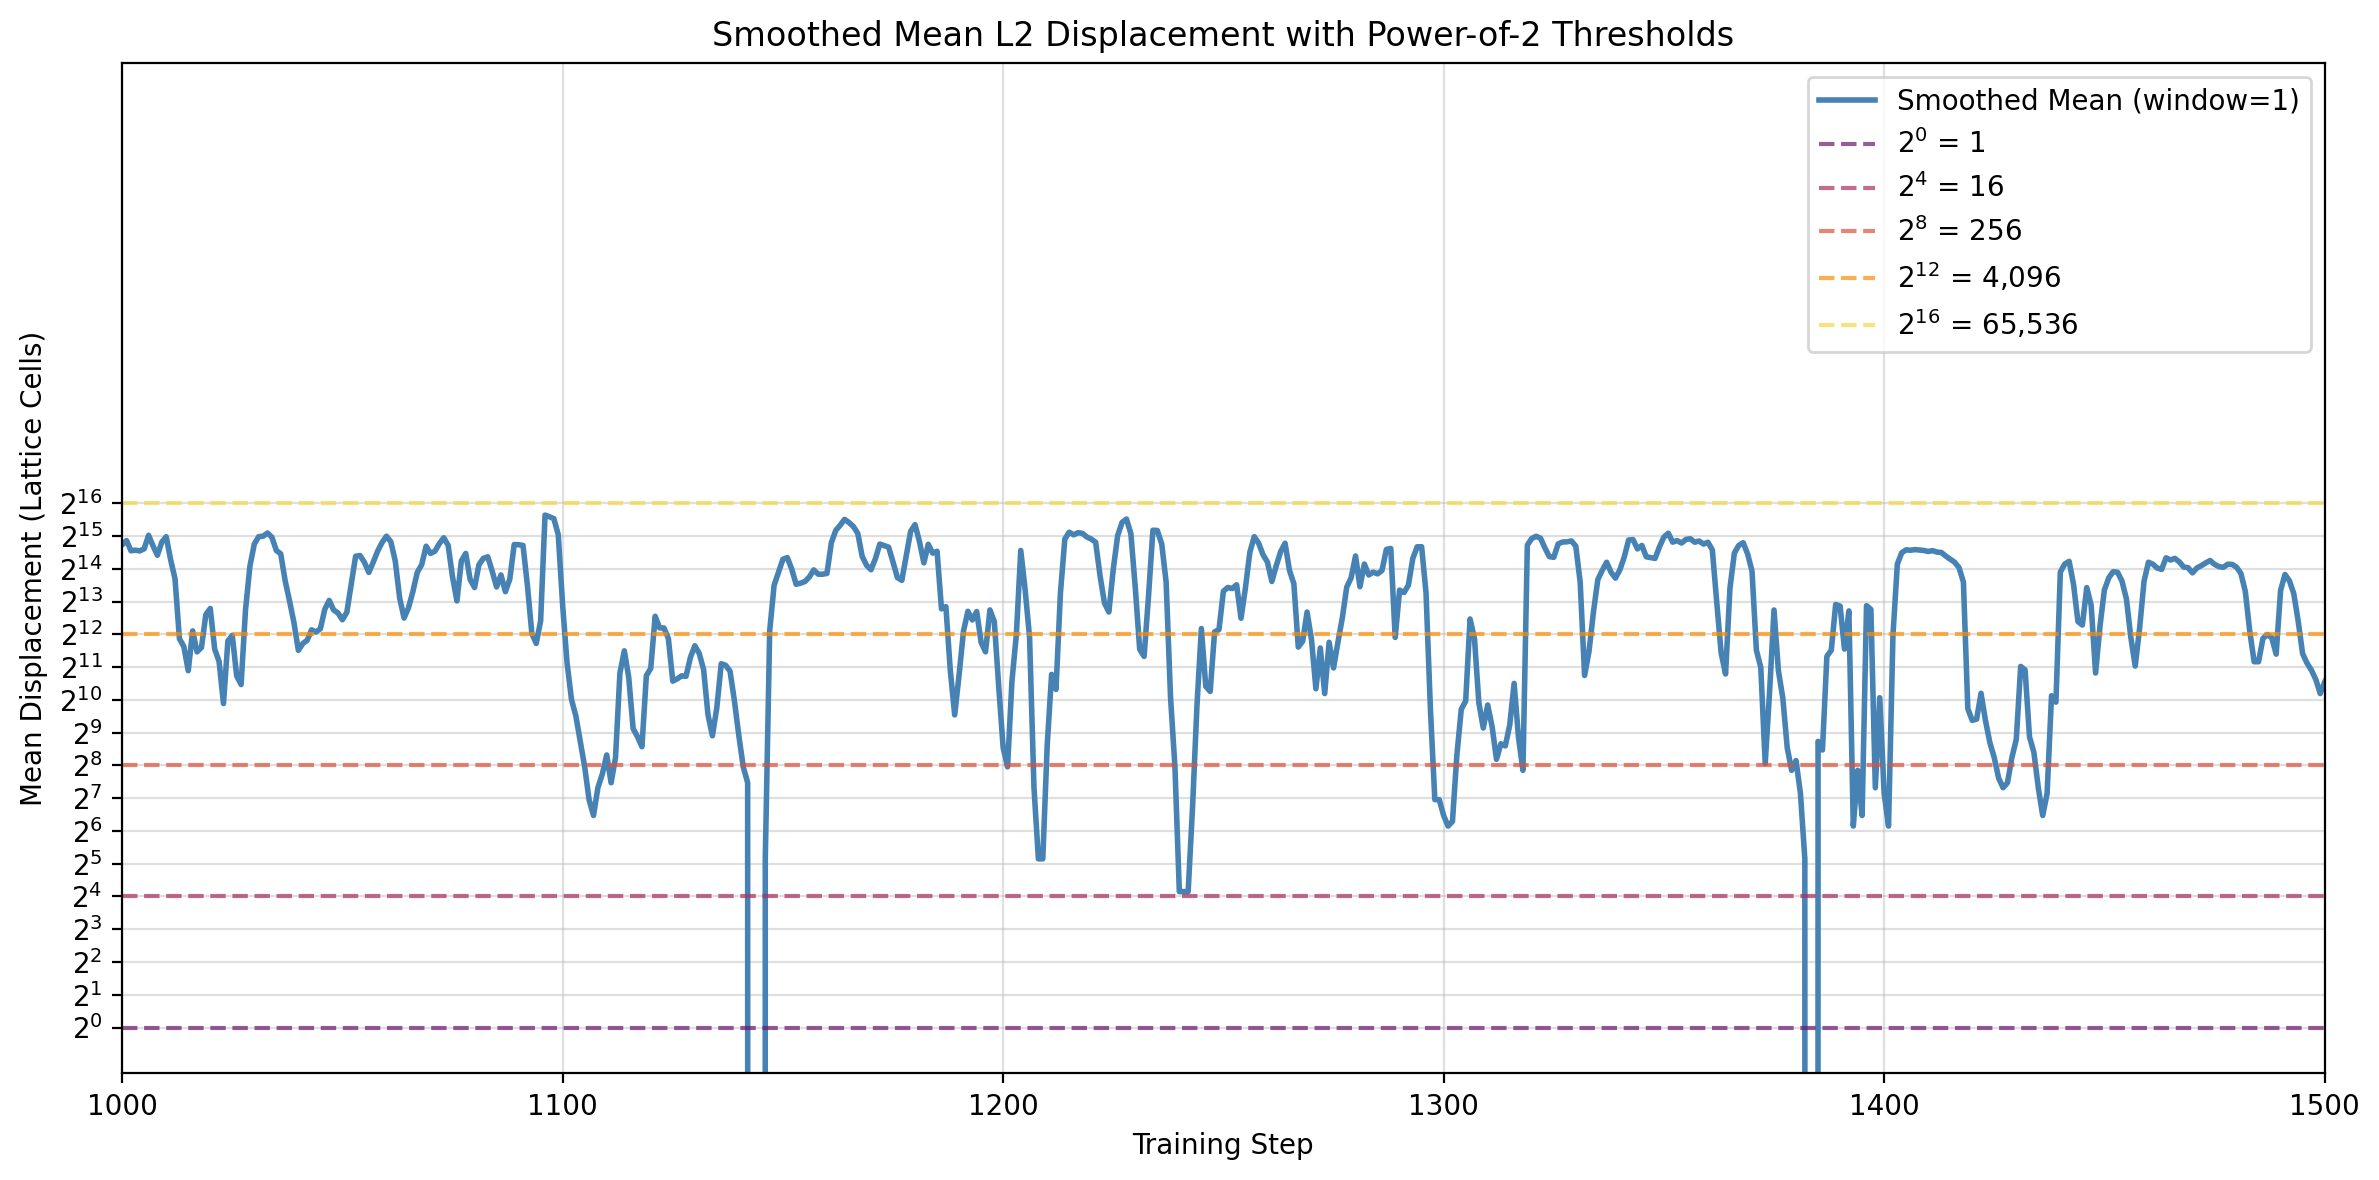

In [81]:
# Compute smoothed mean with rolling window
window_size = 1
mean_l2_smoothed = np.convolve(mean_l2, np.ones(window_size)/window_size, mode='valid')

# Adjust x-axis for convolution (valid mode shortens array)
steps_smoothed = np.arange(window_size-1, 6000)

fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

# Plot smoothed mean
ax.plot(steps_smoothed, mean_l2_smoothed, color='steelblue', linewidth=2, label=f"Smoothed Mean (window={window_size})")

# Add horizontal threshold lines at powers of 2
threshold_powers = [0, 4, 8, 12, 16]
cmap = plt.get_cmap(COLORMAP)
colors = cmap(np.linspace(0.3, 0.9, len(threshold_powers)))

for i, p in enumerate(threshold_powers):
    thresh = 2**p
    ax.axhline(thresh, color=colors[i], linestyle='--', linewidth=1.5, alpha=0.7, label=f'$2^{{{p}}}$ = {thresh:,}')

ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Displacement (Lattice Cells)')
ax.set_title('Smoothed Mean L2 Displacement with Power-of-2 Thresholds')
ax.set_yscale('log', base=2)
ax.set_xlim(1000, 1500)

# Set y-ticks at powers of 2
y_powers = np.arange(0, 17)
ax.set_yticks(2.0 ** y_powers)
ax.set_yticklabels([f'$2^{{{p}}}$' for p in y_powers])

ax.legend(loc='upper right')
ax.grid(True, which='major', alpha=0.4)
ax.grid(True, which='minor', alpha=0.2)

plt.tight_layout()
plt.show()

## Plot 2: Percentiles (L2, Log₂ Scale)

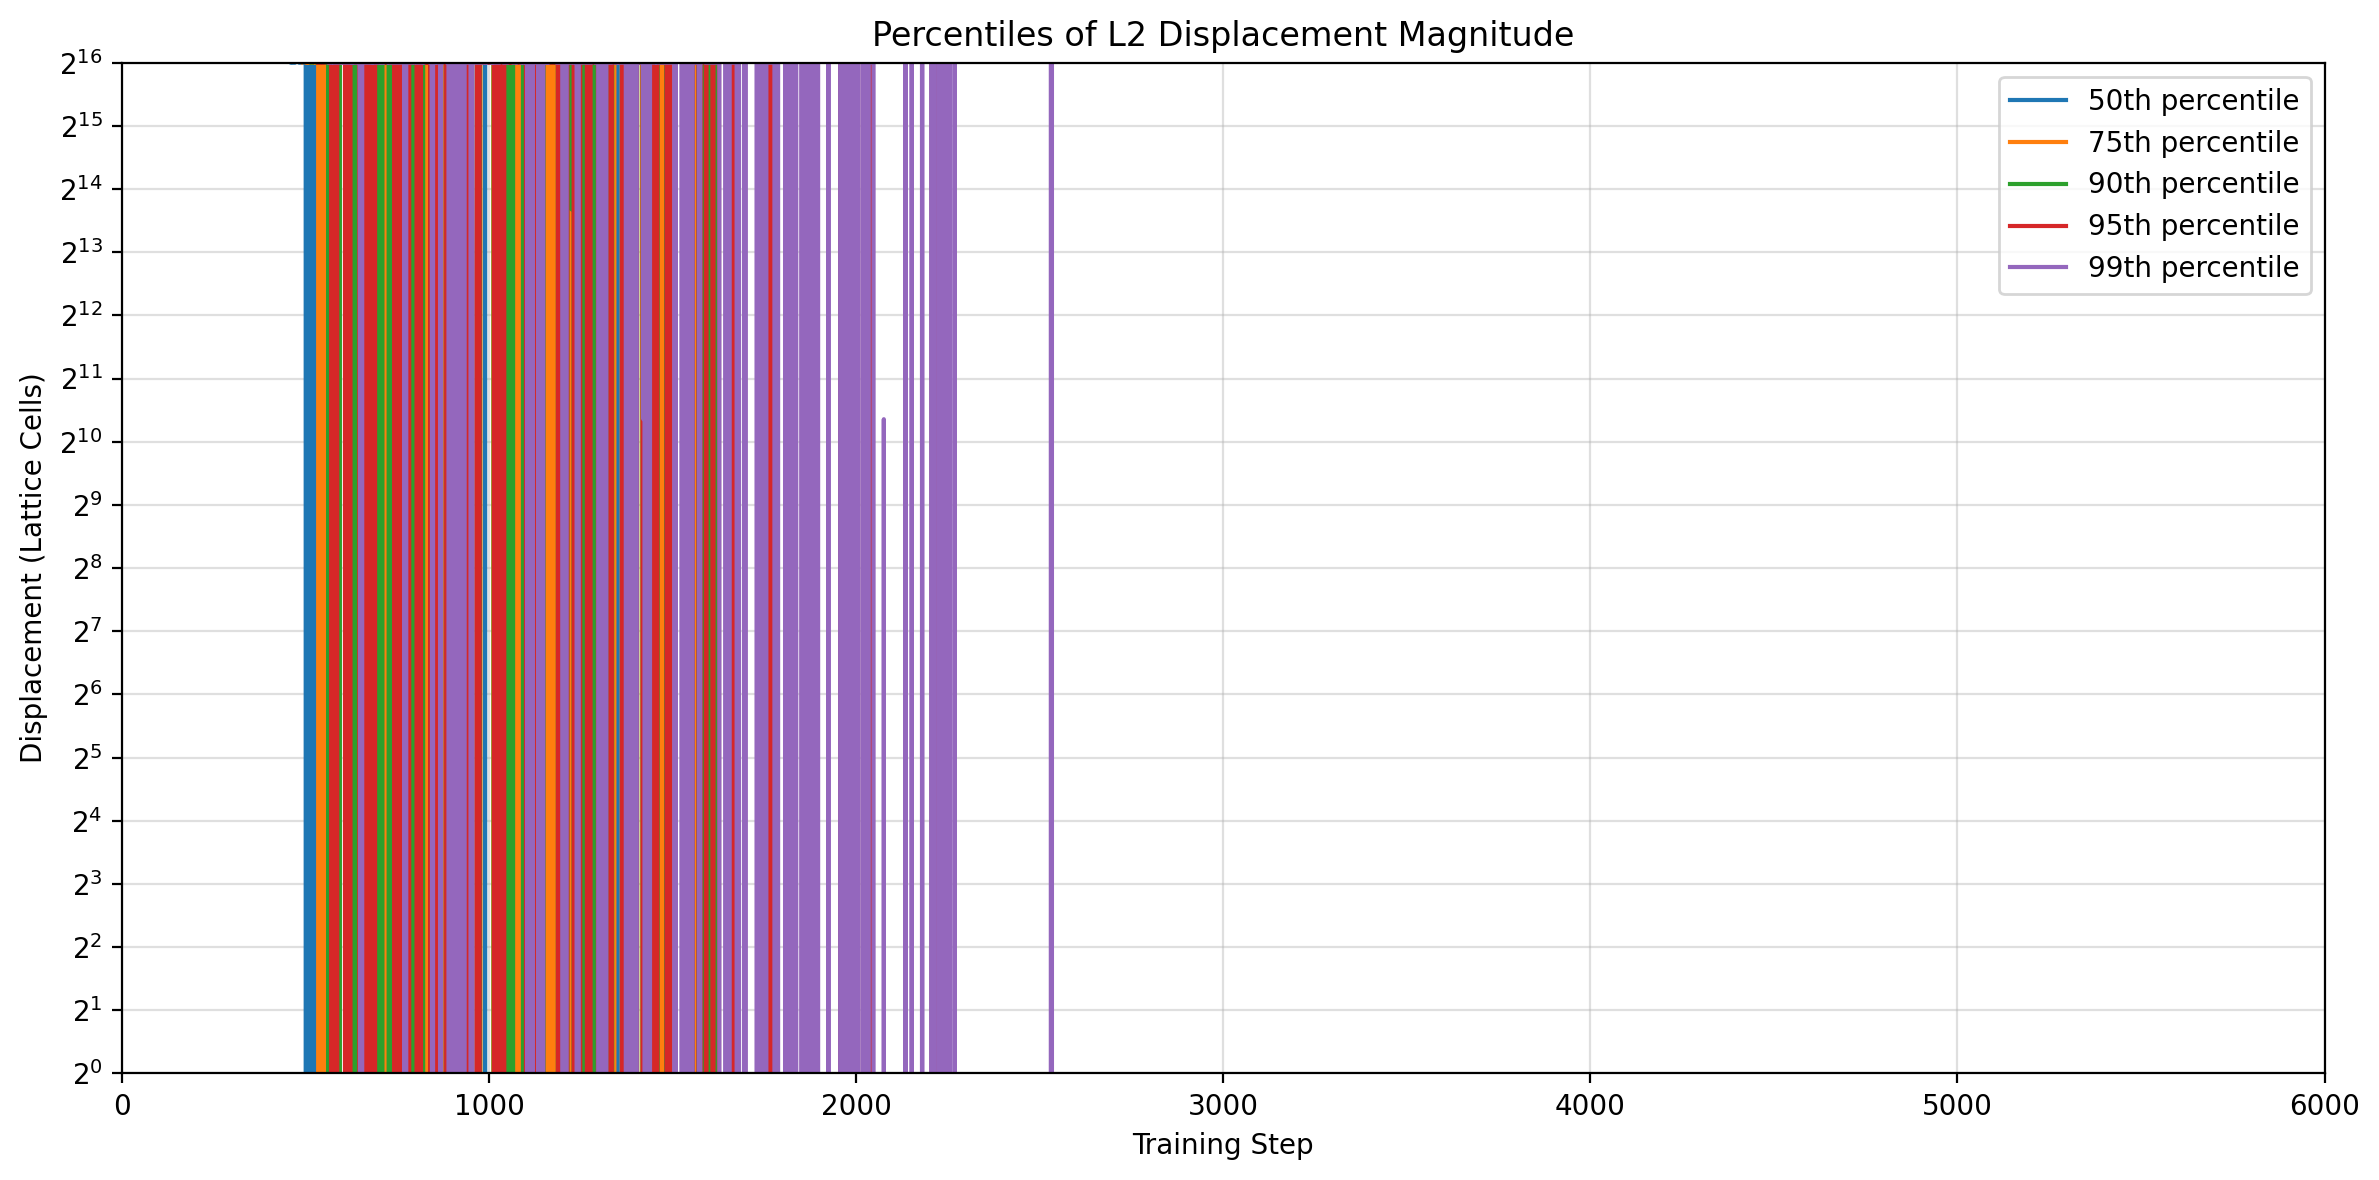

In [82]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

for i, p in enumerate(percentiles):
    ax.plot(perc_values[i], label=f'{p}th percentile', linewidth=1.5)

ax.set_xlabel('Training Step')
ax.set_ylabel('Displacement (Lattice Cells)')
ax.set_title('Percentiles of L2 Displacement Magnitude')
ax.set_yscale('log', base=2)
ax.set_xlim(0, 6000)
ax.set_ylim(1, 65536)

# Set y-ticks at powers of 2
y_powers = np.arange(0, 17)
ax.set_yticks(2.0 ** y_powers)
ax.set_yticklabels([f'$2^{{{p}}}$' for p in y_powers])

ax.legend(loc='best')
ax.grid(True, which='major', alpha=0.4)
ax.grid(True, which='minor', alpha=0.2)

plt.tight_layout()
plt.show()

## Plot 3: Mean L2 Displacement (Log₂ Scale)

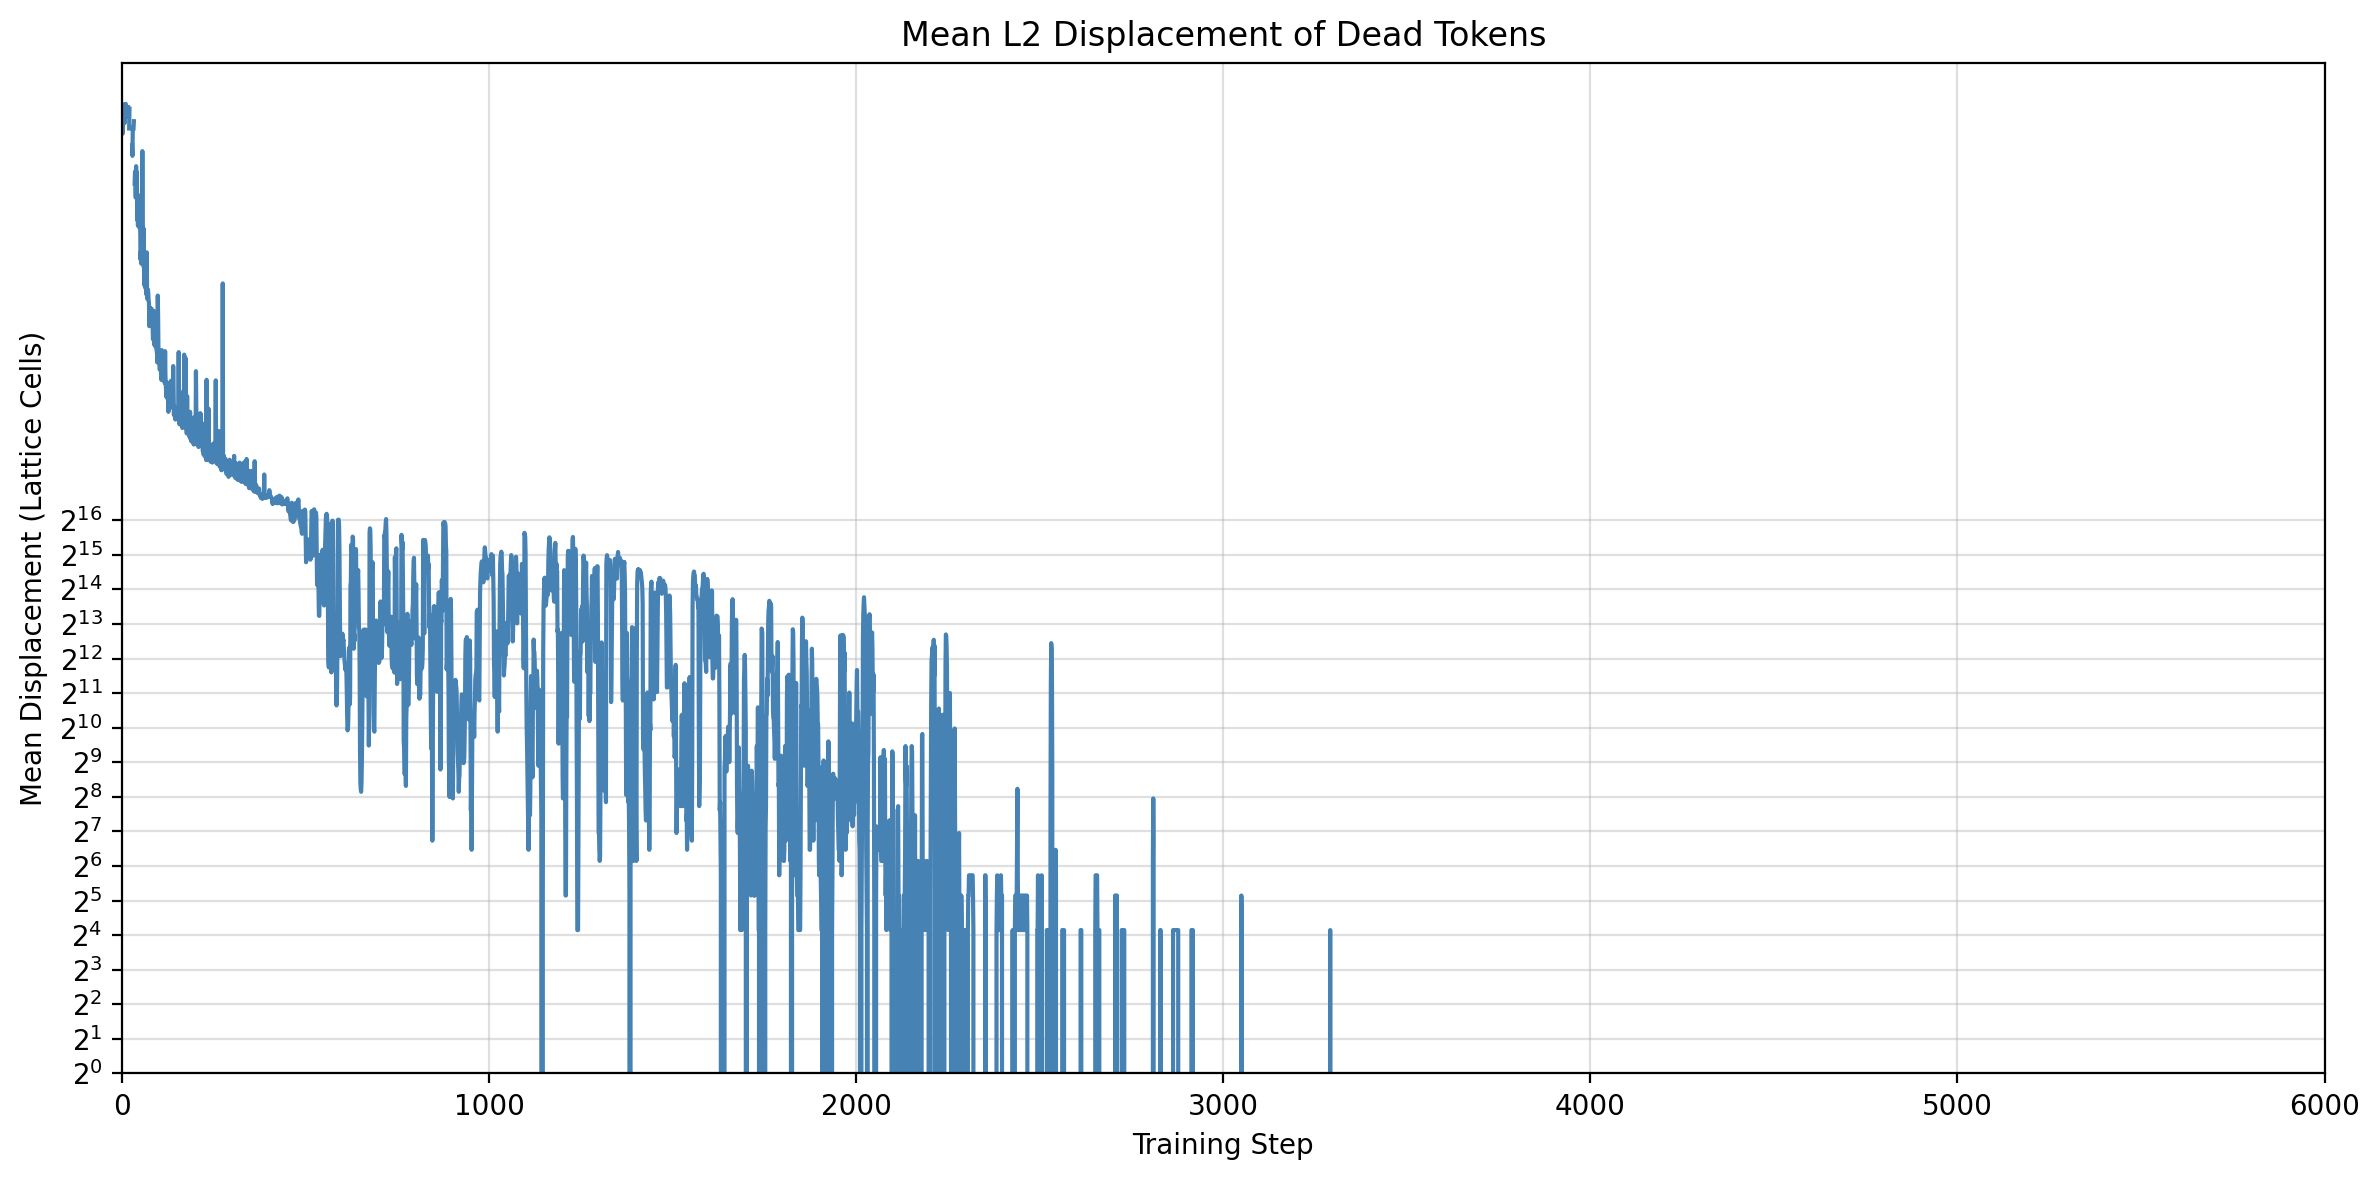

In [83]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

ax.plot(mean_l2, color='steelblue', linewidth=1.5)

ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Displacement (Lattice Cells)')
ax.set_title('Mean L2 Displacement of Dead Tokens')
ax.set_yscale('log', base=2)
ax.set_xlim(0, 6000)

# Set y-ticks at powers of 2
y_powers = np.arange(0, 17)
ax.set_yticks(2.0 ** y_powers)
ax.set_yticklabels([f'$2^{{{p}}}$' for p in y_powers])

ax.grid(True, which='major', alpha=0.4)
ax.grid(True, which='minor', alpha=0.2)

plt.tight_layout()
plt.show()

## Plot 4: Smoothed Mean L∞ Displacement with Threshold Lines

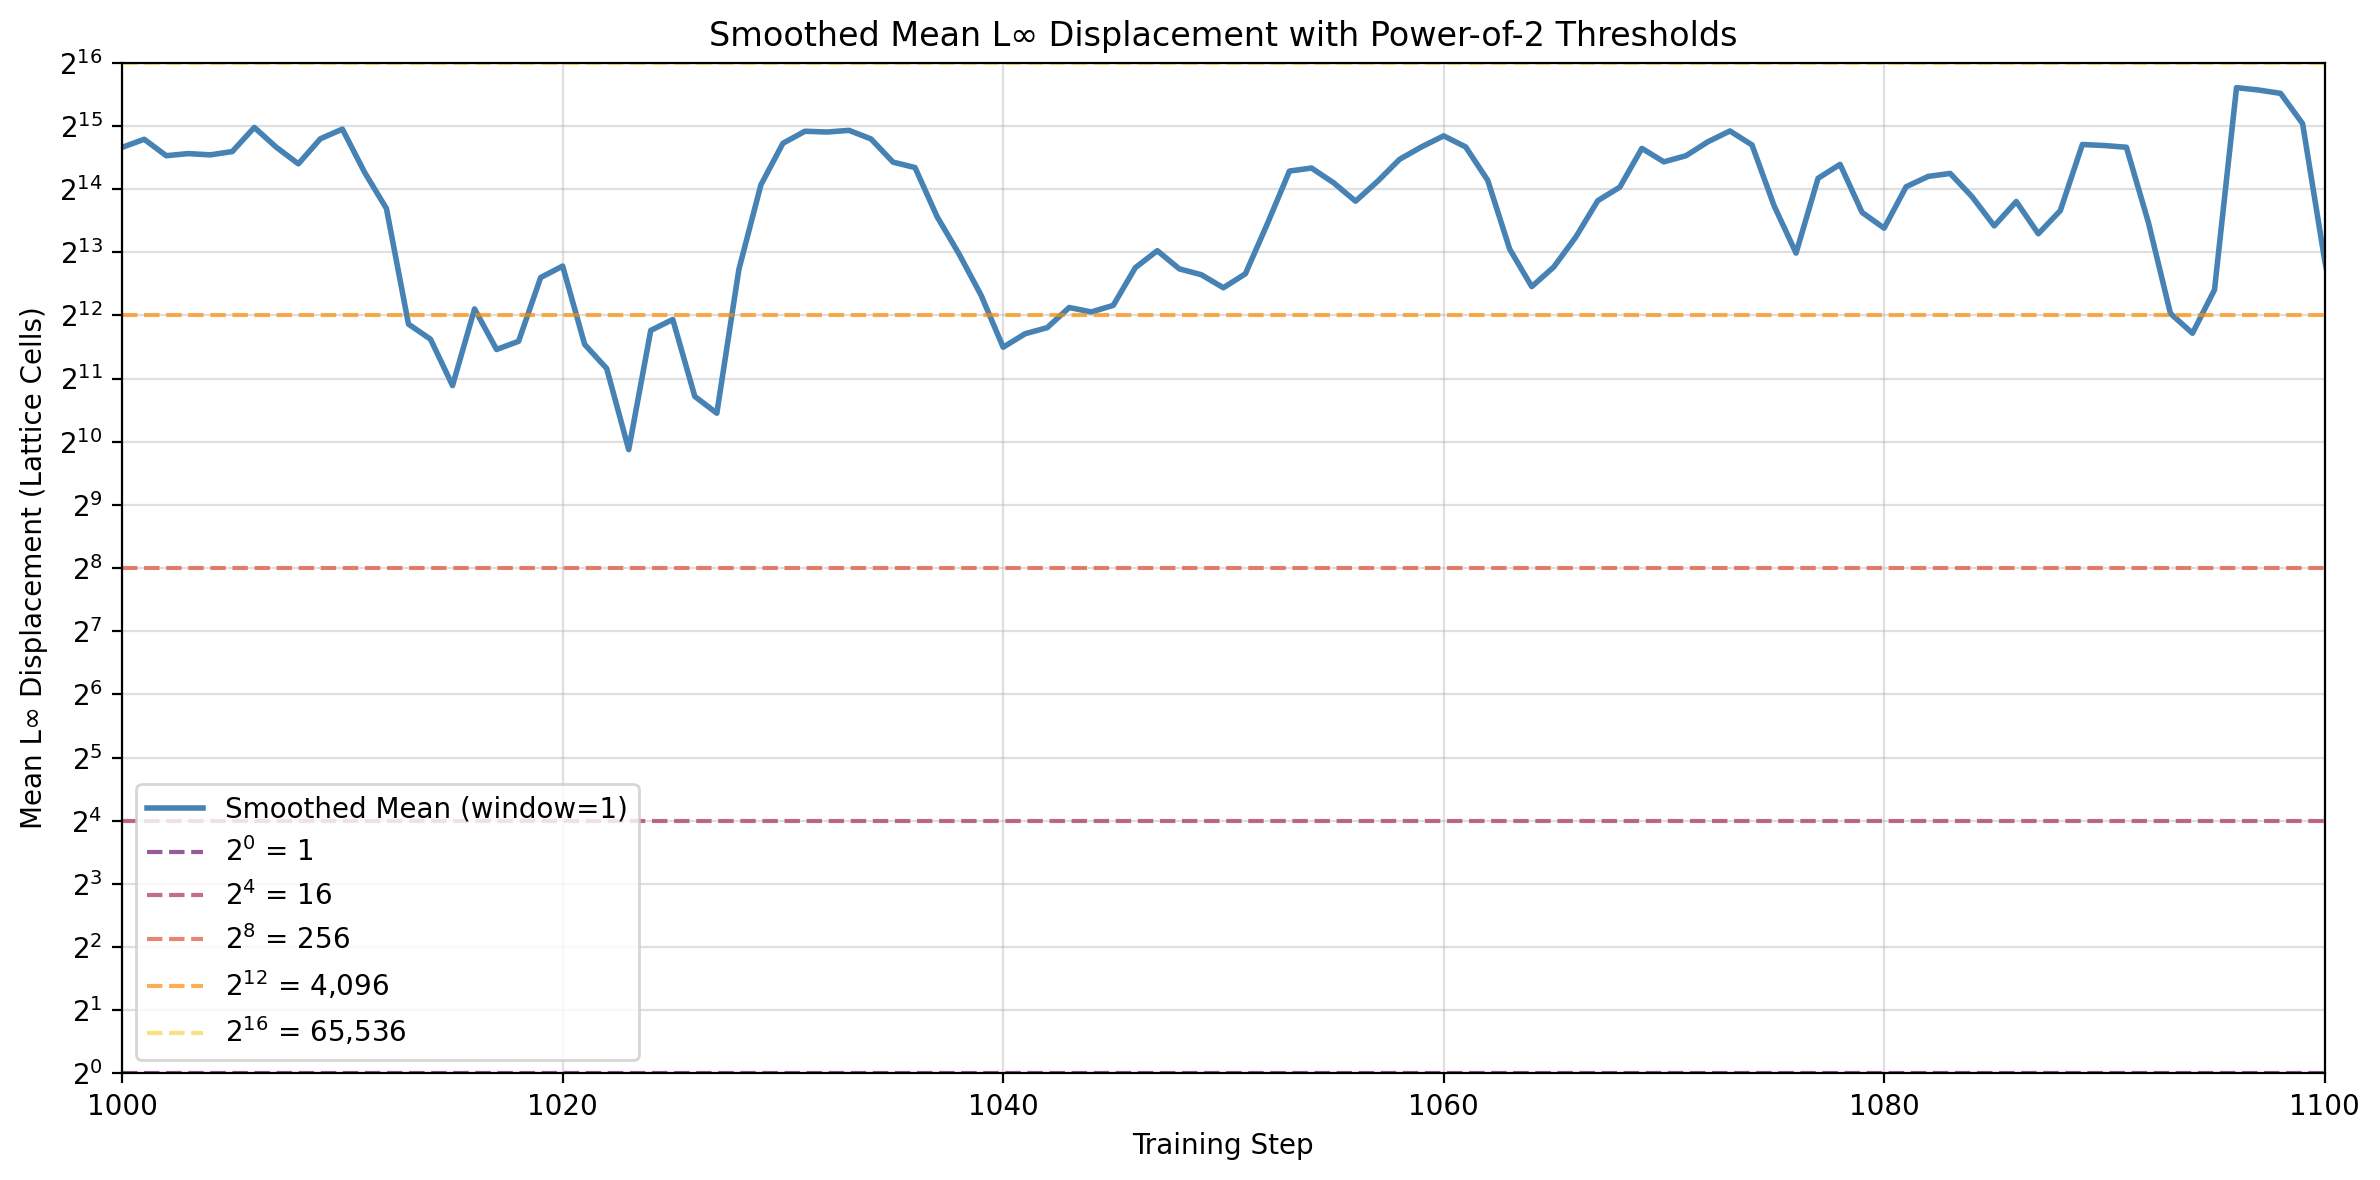

In [88]:
# Compute smoothed mean with rolling window
window_size = 1
mean_linf_smoothed = np.convolve(mean_linf, np.ones(window_size)/window_size, mode='valid')

# Adjust x-axis for convolution (valid mode shortens array)
steps_smoothed = np.arange(window_size-1, 6000)

fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

# Plot smoothed mean
ax.plot(steps_smoothed, mean_linf_smoothed, color='steelblue', linewidth=2, label=f'Smoothed Mean (window={window_size})')

# Add horizontal threshold lines at powers of 2
threshold_powers = [0, 4, 8, 12, 16]
cmap = plt.get_cmap(COLORMAP)
colors = cmap(np.linspace(0.3, 0.9, len(threshold_powers)))

for i, p in enumerate(threshold_powers):
    thresh = 2**p
    ax.axhline(thresh, color=colors[i], linestyle='--', linewidth=1.5, alpha=0.7, label=f'$2^{{{p}}}$ = {thresh:,}')

ax.set_xlabel('Training Step')
ax.set_ylabel('Mean L∞ Displacement (Lattice Cells)')
ax.set_title('Smoothed Mean L∞ Displacement with Power-of-2 Thresholds')
ax.set_yscale('log', base=2)
ax.set_xlim(1000, 1100)
ax.set_ylim(1, 65536)

# Set y-ticks at powers of 2
y_powers = np.arange(0, 17)
ax.set_yticks(2.0 ** y_powers)
ax.set_yticklabels([f'$2^{{{p}}}$' for p in y_powers])

ax.legend(loc='best')
ax.grid(True, which='major', alpha=0.4)
ax.grid(True, which='minor', alpha=0.2)

plt.tight_layout()
plt.show()